**Movie Recommenndation System**
Recommendation system are one of the most popular application in retail, video, music streaming.

Index


*   Collabarative Filtering 
> Memory Based Filtering 

















In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from math import sqrt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [ ]:
!unzip /content/drive/MyDrive/movciesdataset/ratings.csv.zip

Archive:  /content/drive/MyDrive/movciesdataset/ratings.csv.zip
  inflating: ratings.csv             


Loading data

In [ ]:
# Reading ratings file
ratings = pd.read_csv('/content/ratings.csv', sep=',', encoding='latin-1', usecols=['userId','movieId','rating','timestamp'])

# Reading movies file
movies = pd.read_csv('/content/drive/MyDrive/movciesdataset/movies.csv', sep=',', encoding='latin-1', usecols=['movieId','title','genres'])

In [ ]:
movies_data = movies
rating_data = ratings

In [ ]:
print(movies_data.columns)

Index(['movieId', 'title', 'genres'], dtype='object')


In [ ]:
merge_ratings_movies = pd.merge(movies_data, rating_data, on='movieId', how='inner')

In [ ]:
merge_ratings_movies.shape

(100836, 6)

In [ ]:
merge_ratings_movies.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


In [ ]:
merge_ratings_movies = merge_ratings_movies.drop('timestamp', axis=1)

In [ ]:
ratings = ratings.rename(columns={'ItemID': 'movie id'})

In [ ]:
data_movies_ratings=pd.merge(movies, ratings)

In [ ]:
MovieRatings_matrix_items = merge_ratings_movies.pivot_table(index=['movieId'],columns=['userId'],values='rating').reset_index(drop=True)
MovieRatings_matrix_items.fillna( 0, inplace = True )
MovieRatings_matrix_items.shape

(9724, 610)

**Collaborative Filtering**

Types of collaborative filtering techniques

Memory based

*   Item-Item Filtering
*   User-Item Filtering

**ITEM-ITEM FILTERING**

Item-item collaborative filtering, or item-based, or item-to-item, is a form of collaborative filtering for recommender systems based on the similarity between items calculated using people's ratings of those items.

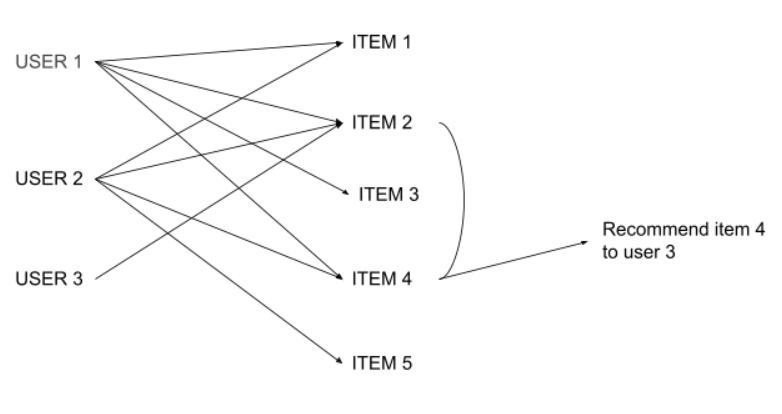








In [ ]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine, correlation

movie_similarity_cosine = 1 - pairwise_distances( MovieRatings_matrix_items.values, metric="cosine" )
np.fill_diagonal( movie_similarity_cosine, 0 ) #Filling diagonals with 0s for future use when sorting is done
ratings_matrix_items_cosine = pd.DataFrame( movie_similarity_cosine )
movie_similarity_cosine = pd.DataFrame(movie_similarity_cosine)

In [ ]:
def movie_similarity(input_movieName):
  movie_index = -1
  movie_index = movies_data[movies_data['title']==input_movieName].index.tolist()
  # print(movie_index)
  if movie_index==-1:
    return False
  else:
    movie_index = movie_index[0]
    movies_data['similarity'] = movie_similarity_cosine.iloc[movie_index]
    movies_data.columns = ['movie_id', 'title', 'release_date','similarity']
    return True

In [ ]:
def recommendedMoviesAsperItemSimilarity(user_id):

    user_similar_movie= merge_ratings_movies[(merge_ratings_movies.userId==user_id) & merge_ratings_movies.rating.isin([5])][['title']]
    user_similar_movie = user_similar_movie.iloc[0,0]
    movie_similarity(user_similar_movie)
    recommend_movies_similarity=movies_data.sort_values( ["similarity"], ascending = False )
    recommend_movies_similarity = movies_data[movies_data['similarity'] >=0.5]['movie_id']
    recommended_movies_dataframe = pd.DataFrame()
    user_movies_list = ratings[ratings['userId']== user_id]['movieId']
    for movie_idx in recommend_movies_similarity:
            if movie_idx not in user_movies_list:
                new_movies= ratings[(ratings.movieId==movie_idx)]
                recommended_movies_dataframe=pd.concat([recommended_movies_dataframe,new_movies])
    return recommended_movies_dataframe #Top_bext_movies['movieId']

In [ ]:
recommended_movies_dataframe = recommendedMoviesAsperItemSimilarity(1)
recommended_movies_dataframe.head()

,userId,movieId,rating,timestamp
15,1,260,5.0,964981680
318,4,260,5.0,945079259
879,7,260,5.0,1106635933
1440,15,260,5.0,1510571946
1573,16,260,3.0,1377476936


In [ ]:
Top_best_movies=recommended_movies_dataframe.sort_values(["rating"], ascending = False )[1:20]
Top_best_movies = Top_bext_movies['movieId']
Top_best_movies.shape

(19,)

In [ ]:
def getMovieNameFromID(listMovieIDs):
    recommend_movies_list= list()
    for id in listMovieIDs:
        recommend_movies_list.append(movies_data[movies_data['movie_id']==id]['title'])
    recommend_movies_list = np.array(recommend_movies_list)
    recommend_movies_list = np.unique(recommend_movies_list)
    return recommend_movies_list

In [ ]:
getMovieNameFromID(Top_best_movies)

array(['Fargo (1996)', 'Forrest Gump (1994)', 'Pulp Fiction (1994)',
       'Silence of the Lambs, The (1991)'], dtype=object)

**USER ITEM FILTERING**

The underlying assumption of the collaborative filtering approach is that if a User1 has the same opinion as a person B on an issue, A is more likely to have User2's opinion on a different issue than that of a randomly chosen perso

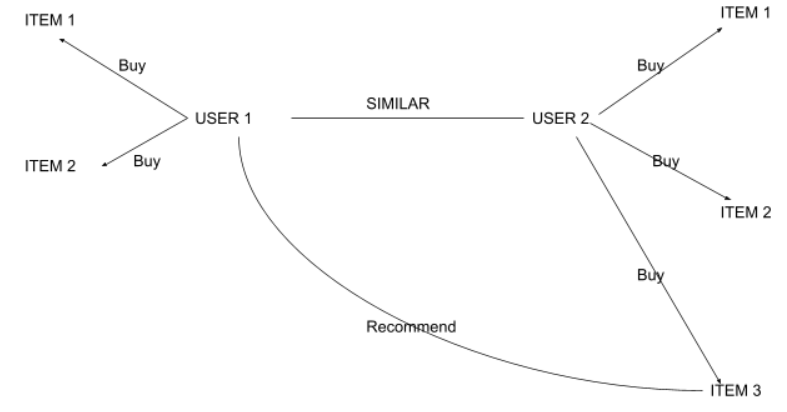



Matrix to store rows as user and columns as movie id

In [ ]:
ratings_movie_users = merge_ratings_movies.pivot_table(index=['userId'],columns=['movieId'],values='rating').reset_index(drop=True)
ratings_movie_users.fillna( 0, inplace = True )

Find the similarity between the using cosine similarity

In [ ]:
movie_similarity = 1 - pairwise_distances( ratings_movie_users, metric="cosine" )
np.fill_diagonal( movie_similarity, 0 ) #Filling diagonals with 0s for future use when sorting is done
ratings_movie_users = pd.DataFrame( movie_similarity )
ratings_movie_users.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609
0,0.000000,0.027283,0.059720,0.194395,0.129080,0.128152,0.158744,0.136968,0.064263,0.016875,0.132499,0.016458,0.092971,0.113238,0.160689,0.169858,0.264358,0.214868,0.325376,0.160969,0.153162,0.050691,0.106669,0.155193,0.099261,0.105791,0.238933,0.202866,0.145251,0.099781,0.164454,0.146211,0.151945,0.083544,0.074508,0.071673,0.144736,0.138588,0.329782,0.094755,...,0.090224,0.131072,0.253480,0.093450,0.062668,0.051803,0.317319,0.0,0.141129,0.249326,0.057399,0.048914,0.052175,0.100406,0.114076,0.123280,0.122782,0.183922,0.118112,0.324766,0.136809,0.143934,0.174413,0.141960,0.110558,0.123713,0.312843,0.011280,0.282412,0.291272,0.080554,0.164455,0.221486,0.070669,0.153625,0.164191,0.269389,0.291097,0.093572,0.145321
1,0.027283,0.000000,0.000000,0.003726,0.016614,0.025333,0.027585,0.027257,0.000000,0.067445,0.044419,0.000000,0.043918,0.016901,0.119778,0.093728,0.103755,0.166253,0.012571,0.014137,0.090880,0.144635,0.013597,0.129902,0.226008,0.000000,0.000000,0.058145,0.104059,0.149324,0.000000,0.017807,0.032428,0.043299,0.000000,0.054012,0.028500,0.023147,0.000000,0.017446,...,0.000000,0.032675,0.167959,0.035531,0.000000,0.000000,0.014870,0.0,0.000000,0.061953,0.136703,0.219315,0.043620,0.000000,0.127551,0.089562,0.000000,0.055900,0.026429,0.056348,0.036147,0.030684,0.062033,0.013125,0.000000,0.104568,0.011986,0.048508,0.098000,0.023248,0.202671,0.016866,0.011997,0.000000,0.000000,0.028429,0.012948,0.046211,0.027565,0.102427
2,0.059720,0.000000,0.000000,0.002251,0.005020,0.003936,0.000000,0.004941,0.000000,0.000000,0.000000,0.000000,0.000000,0.003064,0.017251,0.032299,0.009813,0.028241,0.019142,0.008756,0.004017,0.003070,0.003081,0.002592,0.005100,0.000000,0.002332,0.029771,0.005974,0.000000,0.003507,0.015494,0.007156,0.000736,0.000000,0.000000,0.000000,0.004196,0.003639,0.002530,...,0.020899,0.008056,0.000000,0.000000,0.000000,0.029830,0.039894,0.0,0.005749,0.033121,0.008561,0.000000,0.000000,0.000000,0.000000,0.000986,0.015793,0.003923,0.004791,0.027418,0.000000,0.000000,0.006460,0.001983,0.000000,0.025873,0.028970,0.000000,0.039539,0.013143,0.005048,0.004892,0.024992,0.000000,0.010694,0.012993,0.019247,0.021128,0.000000,0.032119
3,0.194395,0.003726,0.002251,0.000000,0.128659,0.088491,0.115120,0.062969,0.011361,0.031163,0.054767,0.049945,0.076949,0.048989,0.071551,0.164761,0.145058,0.123217,0.206053,0.113755,0.053014,0.043403,0.093971,0.071690,0.032862,0.061832,0.128954,0.135593,0.061308,0.058140,0.126182,0.200597,0.167247,0.045571,0.050148,0.113807,0.061031,0.090125,0.240976,0.053436,...,0.018553,0.182857,0.125627,0.064559,0.061035,0.005932,0.169440,0.0,0.098777,0.148584,0.043871,0.047619,0.048474,0.041246,0.088289,0.064095,0.138766,0.049146,0.064485,0.219298,0.116111,0.068196,0.217116,0.082614,0.091974,0.107908,0.275436,0.016054,0.201610,0.211921,0.085938,0.128273,0.307973,0.052985,0.084584,0.200395,0.131746,0.149858,0.032198,0.107683
4,0.129080,0.016614,0.005020,0.128659,0.000000,0.300349,0.108342,0.429075,0.000000,0.030611,0.183805,0.058860,0.017157,0.221711,0.110152,0.082171,0.162633,0.121313,0.098758,0.096474,0.058264,0.033074,0.066889,0.096215,0.040705,0.294282,0.100491,0.121894,0.068876,0.065534,0.068585,0.233932,0.282323,0.029953,0.311472,0.022065,0.303078,0.377773,0.152956,0.321077,...,0.020016,0.124806,0.129338,0.341347,0.049306,0.000000,0.122199,0.0,0.182382,0.117199,0.057538,0.000000,0.124645,0.348215,0.029293,0.072713,0.154315,0.377256,0.230961,0.152971,0.000000,0.359595,0.171864,0.137990,0.073238,0.096181,0.116071,0.000000,0.098599,0.137053,0.068048,0.418747,0.110148,0.258773,0.148758,0.106435,0.152866,0.135535,0.261232,0.060792


Get the list of user id in dataframe

In [ ]:
similar_user= ratings_movie_users.idxmax(axis=1)
data_similar_user= similar_user.to_frame()
data_similar_user.columns=['similarUser']
data_similar_user.head()

,similarUser
0,265
1,365
2,312
3,390
4,469


Recommend the movies by finding the user having similar taste as the user id provided to the function.

In [ ]:
movieId_list=list()
def getRecommendedMoviesByUserSimilarity(userId):
    user_Movies= ratings[ratings['userId']== userId]['movieId']
    sim_user=data_similar_user.iloc[0,0]
    movie_recommended=pd.DataFrame(columns=['movieId','title','genres','userId','rating','timestamp'])
    for movieId in ratings[ratings['userId']== sim_user]['movieId']:
        if movieId not in user_Movies:
            new_movies= merge_ratings_movies[(merge_ratings_movies.userId==sim_user) & (merge_ratings_movies.movieId==movieId)]
            movie_recommended=pd.concat([movie_recommended,new_movies])
        best10=movie_recommended.sort_values(['rating'], ascending = False )[1:10]  
    return best10['movieId']

Get the top 10 best rated movies for the user id 

In [ ]:
Top_best_movies = getRecommendedMoviesByUserSimilarity(1)

In [ ]:
getMovieNameFromID(Top_best_movies)

array(['African Queen, The (1951)', 'Back to the Future (1985)',
       "It's a Wonderful Life (1946)", 'Matrix, The (1999)',
       'Star Trek II: The Wrath of Khan (1982)',
       'Star Trek IV: The Voyage Home (1986)',
       'Star Wars: Episode IV - A New Hope (1977)',
       'Star Wars: Episode V - The Empire Strikes Back (1980)',
       'X-Men (2000)'], dtype=object)

Evaluating the model by returing the same movies for two users

In [ ]:
def get_user_similar_movies( user1, user2 ):
    similar_movies = merge_ratings_movies[merge_ratings_movies.userId == user1].merge(
      merge_ratings_movies[merge_ratings_movies.userId == user2],
      on = "movieId",
      how = "inner" )
    # print(similar_movies.columns)
    similar_movies.drop(['movieId','genres_x','genres_y','title_y'],axis=1,inplace=True)
    return similar_movies

In [ ]:
get_user_similar_movies(587,511)

,title_x,userId_x,rating_x,userId_y,rating_y
0,Forrest Gump (1994),587,4.0,511,4.5
1,Life Is Beautiful (La Vita Ã¨ bella) (1997),587,5.0,511,4.5
2,"Matrix, The (1999)",587,4.0,511,5.0


Cons for the Memory based filtering are:



*   This method cannot recommend movies for new users.
*   The system need to wait till the new user watch some movies which gives the system knowledge of user interest. 

